# Exercise 1 - MLFlow Quickstart

## What you will learn

In just a few minutes of following along with this quickstart, you will learn:

- How to **log** parameters, metrics, and a model
- The basics of the **MLflow fluent API**
- How to **register** a model during logging
- How to navigate to a model in the **MLflow UI**
- How to **load** a logged model for inference

## Step 1 - Start a Tracking Server

### Set the Tracking Server URI

Ensure that you set the tracking server's uri using:

In [1]:
import mlflow

# setup mlflow
from utils import setup_mlflow

setup_mlflow(
    experiment_name="MLflow Quickstart",
)

True

### Run a local Tracking Server

We're going to start a local MLflow Tracking Server, which we will connect to for logging our data for this quickstart.     
From a terminal, run:

```bash
$ mlflow server \
    --backend-store-uri sqlite:///metadata/mlflow/mlruns.db \
    --default-artifact-root ./metadata/mlflow/mlartifacts \
    --host 0.0.0.0 \
    --port 8080
```


## Step 2 - Train a model and prepare metadata for logging

In this section, we're going to log a model with MLflow. A quick overview of the steps are:

- Load and prepare the Iris dataset for modeling.
- Train a Logistic Regression model and evaluate its performance.
- Prepare the model hyperparameters and calculate metrics for logging.

In [7]:
from mlflow.models import infer_signature

import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Load the Iris dataset
X, y = datasets.load_iris(return_X_y=True)

# Exploring the dataset
datasets.load_iris(as_frame=True)["frame"].sample(n=20)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
99,5.7,2.8,4.1,1.3,1
26,5.0,3.4,1.6,0.4,0
7,5.0,3.4,1.5,0.2,0
1,4.9,3.0,1.4,0.2,0
33,5.5,4.2,1.4,0.2,0
136,6.3,3.4,5.6,2.4,2
24,4.8,3.4,1.9,0.2,0
79,5.7,2.6,3.5,1.0,1
57,4.9,2.4,3.3,1.0,1
100,6.3,3.3,6.0,2.5,2


In [8]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define the model hyperparameters
params = {
    "solver": "lbfgs",
    "max_iter": 1000,
    "random_state": 8888,
}

# Train the model
lr = LogisticRegression(**params)
lr.fit(X_train, y_train)

# Predict on the test set
y_pred = lr.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"The accuracy of the model on the test dataset is: {accuracy}")

The accuracy of the model on the test dataset is: 1.0


## Step 3 - Log the model and its metadata to MLflow

In this next step, we're going to use the model that we trained, the hyperparameters that we specified for the model's fit, and the loss metrics that were calculated by evaluating the model's performance on the test data to log to MLflow.

The steps that we will take are:

- Initiate an MLflow **run** context to start a new run that we will log the model and metadata to.
- **Log** model **parameters** and performance **metrics**.
- **Tag** the run for easy retrieval.
- **Register** the model in the MLflow Model Registry while **logging** (saving) the model.

In [9]:
# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Basic LR model for iris data")

    # Infer the model signature
    signature = infer_signature(X_train, lr.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=lr,
        artifact_path="iris_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="tracking-quickstart",
    )

Registered model 'tracking-quickstart' already exists. Creating a new version of this model...
Created version '2' of model 'tracking-quickstart'.


## Step 4 - Load the model as a Python Function (pyfunc) and use it for inference

After logging the model, we can perform inference by:

- **Loading** the model using MLflow's pyfunc flavor.
- Running **Predict** on new data using the loaded model.

In [10]:
# Load the model back for predictions as a generic Python Function model
loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)

predictions = loaded_model.predict(X_test)

iris_feature_names = datasets.load_iris().feature_names

result = pd.DataFrame(X_test, columns=iris_feature_names)
result["actual_class"] = y_test
result["predicted_class"] = predictions

result[:4]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),actual_class,predicted_class
0,6.1,2.8,4.7,1.2,1,1
1,5.7,3.8,1.7,0.3,0,0
2,7.7,2.6,6.9,2.3,2,2
3,6.0,2.9,4.5,1.5,1,1


## Step 6 - View the Run in the MLflow UI

In order to see the results of our run, we can navigate to the MLflow UI. Since we have already started the Tracking Server at http://localhost:8080, we can simply navigate to that URL in our browser.    
Beware that depending on the version of MLFlow that you have, the interface may vary in its form (but the same features shall be found anyway).

When opening the site, you will see a screen similar to the following:

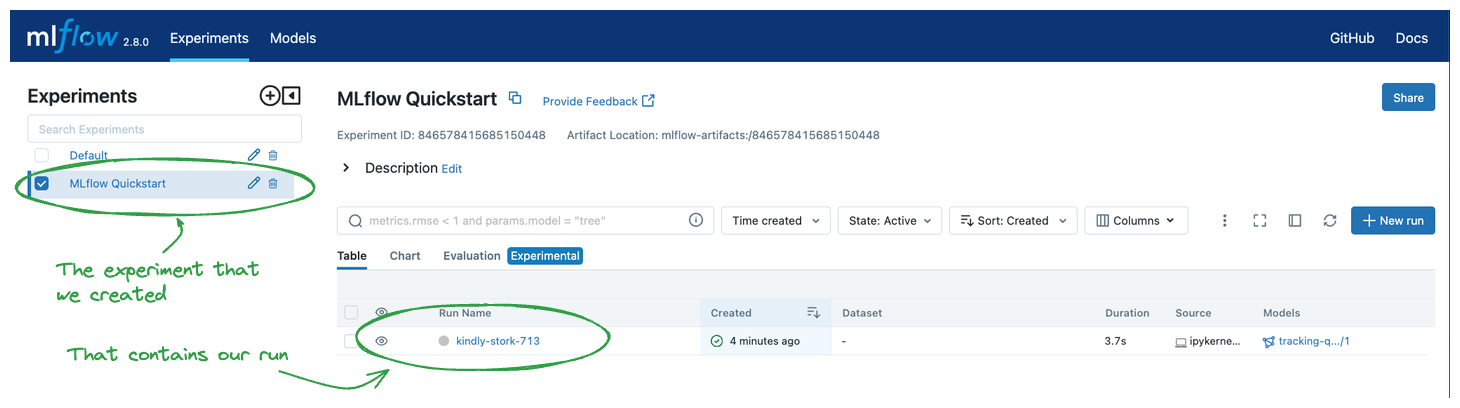

Clicking on the name of the Experiment that we created ("MLflow Quickstart") will give us a list of runs associated with the Experiment. You should see a random name that has been generated for the run and nothing else show up in the Table list view to the right.

Clicking on the name of the run will take you to the Run page, where the details of what we've logged will be shown. The elements have been highlighted below to show how and where this data is recorded within the UI.

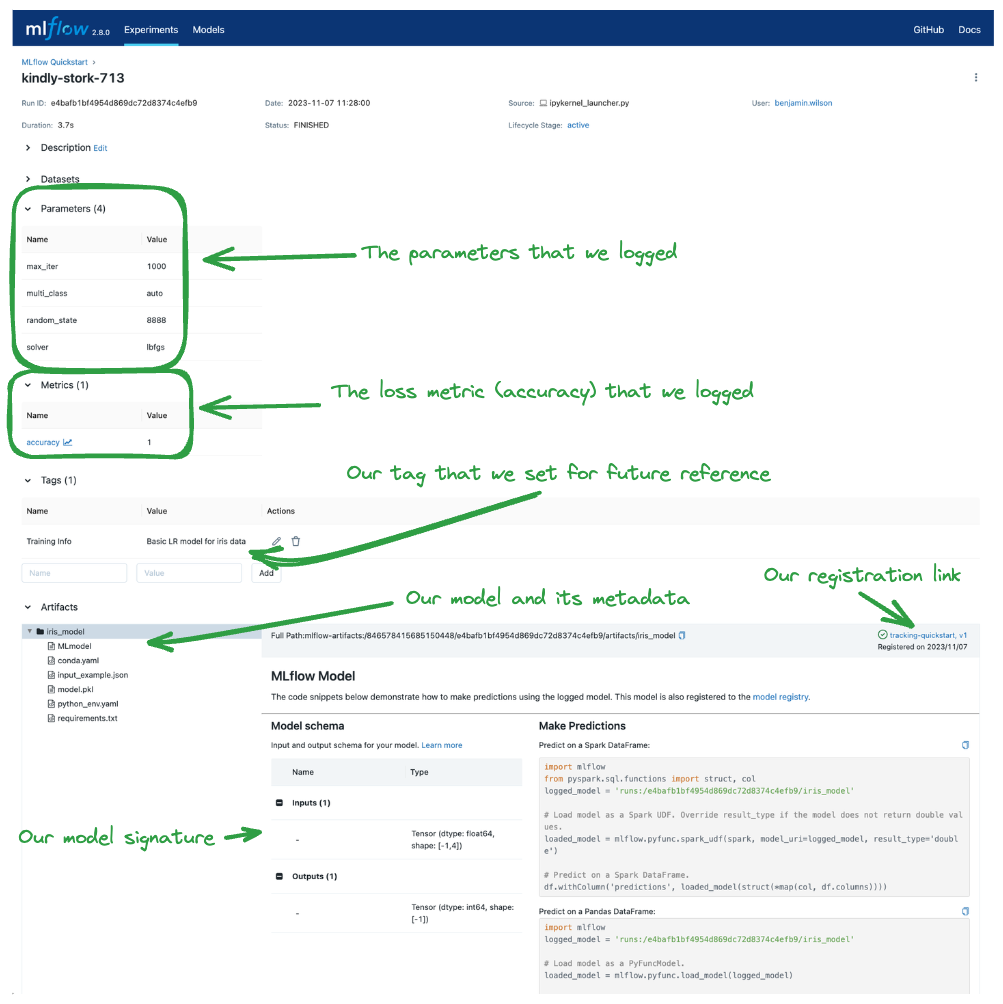

## Conclusion

Congratulations on working through this first MLFlow exercise! You should now have a basic understanding of how to use the MLflow Tracking API to log models.